In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from netlens.modules import Normalization
from netlens.style_transfer import *
from netlens.prep import *

In [2]:
from datetime import datetime
from pathlib import Path
import json
from fastai.basic_train import load_learner
import torch.optim
from netlens.visualization.render import *
from netlens.visualization import param


## Learnings so far
* Less injects, faster converge
* Earlier layers injects -> more rough
* Later layers injects -> more fine

In [55]:
img_path = "../../images/style_transfer/"

In [56]:
muse_paths = [img_path + name for name in ["lucia.jpg", "sulafa.jpg", "min.jpg"]]
style_paths = [img_path + name for name in ["bellmer.jpg", "hendrix.jpg", "kandinsky.jpg"]]

In [57]:
#we use paths in the config, this is just to see the data
muses = [image_loader(muse) for muse in muse_paths]
styles = [image_loader(style) for style in style_paths]


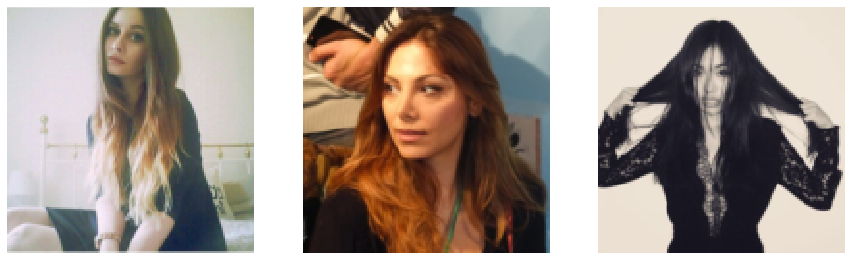

In [58]:
show_images(muses)

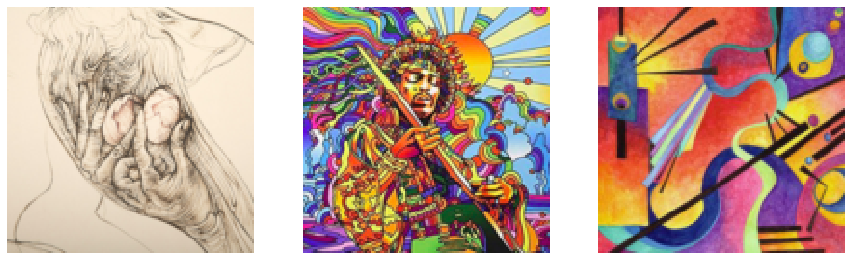

In [59]:
show_images(styles) #go figure ;)

In [60]:
class STCallback(OptVisCallback):
    
    def __init__(self, path, config):
        self.path = path
        self.config = config
    
    def on_step_begin(self, optvis, img, *args, **kwargs):
        img.data.clamp_(0.0, 1.0)
        
    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.is_step_to_show():
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')
            
    def on_render_end(self, optvis, img, *args, **kwargs):
        img.data.clamp_(0.0, 1.0)
        image = img.cpu().clone()  # we clone the tensor to not do changes on it
        image = image.squeeze(0)      # remove the fake batch dimension
        image = unloader(image)
        
        
        iteration = optvis.run
        SL = optvis.objective.style_loss.item()
        CL = optvis.objective.content_loss.item()
        fname = f'{iteration}_SL_{SL}_CL_{CL}'
        self.config["outputs"].append({"iteration": iteration, "image": fname, "style_loss": SL, "content_loss": CL})
        image.save(self.path / (fname + ".jpg"), 'JPEG')


In [106]:
#add %timer to params -- know how long the training took
from numpy import random
from netlens.visualization.param import RawParam

#dirty one-off function
def hyperparam_traverse(config, use_noise=False, verbose=True):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = config["model_path"], file = config["model"])
    
    #cnn = models.vgg19(pretrained=True).features.to(device).eval()
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    #python doesn't have nice destructuring for dicts ... lame
    style_weight = config["style_weight"]
    content_weight = config["content_weight"]
    tv_weight = config["tv_weight"]
    
    arch = FlatModel.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    
    #iteration logic later
    for pair in config["style_content_pairs"]:

        style_p = pair[0]
        content_p = pair[1]
        style_img = image_loader(style_p)
        style_img = style_img[:, :3, :, :512]

        content_img = image_loader(content_p)    

        assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"

        #luckily content doesn't vary...
        content_injects = config["content_injects"]

        #for loop here over permutations
        for content_inject in config['content_injects']:
            for style_inject in config["style_injects"]:

                style_module = StyleTransferModule(
                    arch, 
                    content_target=content_img, 
                    content_layer_keys=content_inject, #TRY AGAIN WITH CONTENT 
                    style_target=style_img, 
                    style_layer_keys=style_inject)


                style_obj = StyleTransferObjective(style_module, style_weight=style_weight, 
                                                   content_weight=content_weight, tv_weight=tv_weight)


                optvis = OptVis(style_module, style_obj, optim=optim.LBFGS, in_closure=True)

                if not config["raw_parameter"]:
                    image_param = param.ImageParam(im_initial=content_img, fft=config["fft"], 
                                                   decorrelate=config["decorrelate"])
                else:
                    image_param = RawParam(content_img)

                    #TODO try noise instead
                 #TODO try noise instead
                if use_noise: 
                    input_img = torch.rand(content_img.size()).to(device)
                else:
                    input_img = content_img.clone()
                # style_injects = config["style_injects"]
                folder_name = "style"
                for s in style_inject:
                    folder_name += "-" + s.split("-")[1]
                folder_name += "_content"
                for c in content_inject:
                    folder_name += "-" + c.split("-")[1]
                folder_name += "/"

                filepath = outpath + folder_name

                p = Path(filepath)
                print(p)
                p.mkdir(parents=True, exist_ok=True)
                conf = config.copy()
                conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
                conf["outputs"] = []

                conf["style_injects"] = style_inject
                conf["content_injects"] = content_inject  

                output = optvis.vis(image_param, thresh=tuple(config["tresh"]), 
                                    transform=True, show=True, callback=STCallback(p, conf))


                         #print(str(style_inject))
               # output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], style_weight=config["style_weight"], content_weight=config["content_weight"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=verbose)


                #SAVE CONFIG
                confpath = filepath + "config.json"

                #json.dump(conf, default=lambda o: o.__dict__, indent=4)
                with open(confpath, 'w') as outfile:
                    print(confpath)
                    json.dump(conf, outfile)
            show_image(output)
    torch.cuda.empty_cache()
    return output 
   

In [109]:
combos = [[style, muse] for style, muse in zip(style_paths, muse_paths)]
combos

[['../../images/style_transfer/bellmer.jpg',
  '../../images/style_transfer/lucia.jpg'],
 ['../../images/style_transfer/hendrix.jpg',
  '../../images/style_transfer/sulafa.jpg'],
 ['../../images/style_transfer/kandinsky.jpg',
  '../../images/style_transfer/min.jpg']]

In [110]:
batch_config = {
    "model_path": "../../../models",
    "model": "vgg19_age_2.pkl", 
    "loss_func": "",
    "style_content_pairs":  
        #can run multiple pair, inputs
        #styles first
        combos
    ,
    "style_injects":[['conv-5']],
    "content_injects": [['conv-4',"conv-7"]],
    "style_weight": 1000000,
    "content_weight": 1,
    #['conv-5'], ['conv-4', 'conv-7'] -- was good 
    "tresh": [100,200,300, 500],
    "tv_weight": 0.001,
    "output_path":"../../../style_experiments/",
    "fft": False, #those have still issues
    "decorrelate":False,
    "raw_parameter": True
}


../../../style_experiments/style-5_content-4-7
Run [50], loss=2548.8545
Style loss=2381.99853515625, Content loss=162.75350952148438, TV loss=4.102505207061768
Run [100], loss=1576.4655


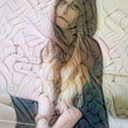

Style loss=1378.885009765625, Content loss=193.80177307128906, TV loss=3.778730869293213
Run [150], loss=17551.0020
Style loss=17392.76953125, Content loss=154.00503540039062, TV loss=4.226761817932129
Run [200], loss=1520.6625


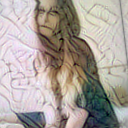

Style loss=1322.9039306640625, Content loss=193.73263549804688, TV loss=4.025827884674072
Run [250], loss=968.2474
Style loss=770.1159057617188, Content loss=193.90017700195312, TV loss=4.231281757354736
Run [300], loss=3193.6003


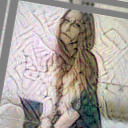

Style loss=2982.585205078125, Content loss=206.56155395507812, TV loss=4.45349645614624
Run [350], loss=1960.1486
Style loss=1793.2352294921875, Content loss=162.18418884277344, TV loss=4.729159832000732
Run [400], loss=964.6116
Style loss=759.145751953125, Content loss=201.1144561767578, TV loss=4.3514275550842285
Run [450], loss=6023.2764
Style loss=5788.03759765625, Content loss=227.85940551757812, TV loss=7.379179954528809
Run [500], loss=1308.1085


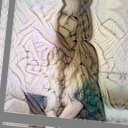

Style loss=1096.2340087890625, Content loss=207.52877807617188, TV loss=4.345722675323486
../../../style_experiments/style-5_content-4-7/config.json


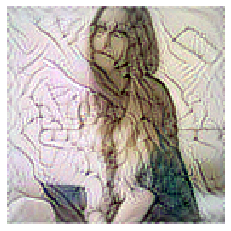

../../../style_experiments/style-5_content-4-7
Run [50], loss=37378.8516
Style loss=36835.41015625, Content loss=536.2613525390625, TV loss=7.179303169250488
Run [100], loss=42605.4688


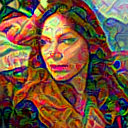

Style loss=41952.265625, Content loss=645.7625732421875, TV loss=7.441519737243652
Run [150], loss=11689.9678
Style loss=11137.716796875, Content loss=545.2702026367188, TV loss=6.980556011199951
Run [200], loss=22906.7910


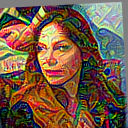

Style loss=22202.193359375, Content loss=695.607421875, TV loss=8.989301681518555
Run [250], loss=7546.3345
Style loss=6927.76123046875, Content loss=611.1824951171875, TV loss=7.390732765197754
Run [300], loss=8072.4126


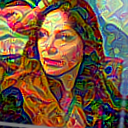

Style loss=7399.7783203125, Content loss=664.95703125, TV loss=7.677308082580566
Run [350], loss=5744.7798
Style loss=5110.1904296875, Content loss=626.885498046875, TV loss=7.703671455383301
Run [400], loss=8258.9688
Style loss=7572.12255859375, Content loss=678.946044921875, TV loss=7.899951934814453
Run [450], loss=47125.6211
Style loss=46551.75, Content loss=565.868896484375, TV loss=8.00483512878418
Run [500], loss=4309.4575


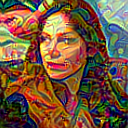

Style loss=3686.47802734375, Content loss=614.653564453125, TV loss=8.325668334960938
../../../style_experiments/style-5_content-4-7/config.json


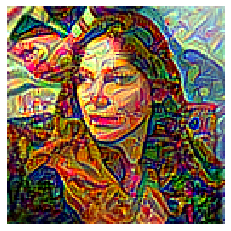

../../../style_experiments/style-5_content-4-7
Run [50], loss=22451.0293
Style loss=21911.37890625, Content loss=533.425537109375, TV loss=6.224796295166016
Run [100], loss=10002.3740


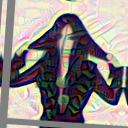

Style loss=9493.5185546875, Content loss=503.7238464355469, TV loss=5.132225036621094


In [ ]:
styled = hyperparam_traverse(batch_config, verbose=False);

In [ ]:
show_image(styled)

In [ ]:
batch_config["model"] = "imdb-sample-vgg19-unfr.pkl"

In [ ]:
from itertools import product, chain, combinations, permutations
from random import sample 
conv_layer_indices = list(range(0, 16))

In [ ]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(list(range(0, 16))) if subs != () ]

In [ ]:

samp = sample(layer_combos,k=1000)
samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]
samp_layers[:3]

In [ ]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
bc["content_injects"] = samp_layers

In [ ]:
hyperparam_traverse(bc, verbose=False)